# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import os
import pandas as pd
import numpy as np
%conda install -c anaconda ydata-profiling
from ydata_profiling import ProfileReport
import seaborn as sns
from sklearn.model_selection import train_test_split
!pip install lightgbm
import lightgbm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import OrdinalEncoder
import time
import matplotlib.pyplot as plt
from sklearn.metrics import  make_scorer
from sklearn.dummy import DummyRegressor

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
pth1_train = '/datasets/autos.csv'
pth2_train = 'autos.csv'

if os.path.exists(pth1_train):
    data = pd.read_csv(pth1_train)
elif os.path.exists(pth2_train):
    data = pd.read_csv(pth2_train)
else:
    print('Something is wrong')

In [3]:
profil = ProfileReport(data, title='Data Profiling')
profil

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
data.drop(columns = ['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth'], inplace=True)

- Удалил колонки не нужные для определения стоимости 

In [5]:
data['VehicleType'] = data['VehicleType'].fillna('other')
data['Gearbox'] = data['Gearbox'].fillna('not indicated')
data['Model'] = data['Model'].fillna('not indicated')
data['FuelType'] = data['FuelType'].fillna('not indicated')
data['Repaired'] = data['Repaired'].fillna('not indicated')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [6]:
data.head()

Price VehicleType  RegistrationYear Gearbox  Power          Model  \
0    480       other              1993  manual      0           golf   
1  18300       coupe              2011  manual    190  not indicated   
2   9800         suv              2004    auto    163          grand   
3   1500       small              2001  manual     75           golf   
4   3600       small              2008  manual     69          fabia   

   Kilometer  FuelType       Brand       Repaired  
0     150000    petrol  volkswagen  not indicated  
1     125000  gasoline        audi            yes  
2     125000  gasoline        jeep  not indicated  
3     150000    petrol  volkswagen             no  
4      90000  gasoline       skoda             no

In [7]:
profil = ProfileReport(data, title='Data Profiling')
profil

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
def plotbox (data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    print(data[column].describe())
    q1_iqr = q1 - 1.5*iqr
    q3_iqr = q3 + 1.5*iqr
    data = data.query('@q1_iqr <= @data[@column] <= @q3_iqr')
    
    sns.boxplot(x = column , data = data).set_title(column)
    
    return data  

In [9]:
data = plotbox(data, 'RegistrationYear')

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


In [10]:
data = plotbox(data, 'Price')

count    348060.000000
mean       4394.435543
std        4496.463401
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6300.000000
max       20000.000000
Name: Price, dtype: float64


In [11]:
data = plotbox(data,'Power')

count    329078.000000
mean        106.680279
std         190.501193
min           0.000000
25%          68.000000
50%         102.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64


In [12]:
data = data.query('50 <= Power')
data = data.query('200 <= Price')
data = data.query('RegistrationYear <= 2016')

In [13]:
data[['Power', 'Price', 'RegistrationYear']].describe(include='all')

Power          Price  RegistrationYear
count  261163.000000  261163.000000     261163.000000
mean      115.041801    4052.017368       2002.894629
std        42.952668    3440.639528          5.491276
min        50.000000     200.000000       1986.000000
25%        75.000000    1300.000000       1999.000000
50%       109.000000    2900.000000       2003.000000
75%       143.000000    5999.000000       2007.000000
max       248.000000   14150.000000       2016.000000

In [14]:
data.duplicated().sum()

35946

In [15]:
data = data.drop_duplicates().reset_index(drop=True)

In [16]:
features = data.drop('Price', axis = 1)
target = data['Price']
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.2, 
                                                                              random_state=12345
                                                                             )

In [17]:
features_train_enc = features_train.copy()
features_valid_enc = features_valid.copy()
columns_enc = features_train.select_dtypes("object").columns.tolist()

ord_enc = OrdinalEncoder()
ord_enc.fit(features[columns_enc])
features_train_enc[columns_enc] = ord_enc.transform(features_train_enc[columns_enc])
features_valid_enc[columns_enc] = ord_enc.transform(features_valid_enc[columns_enc])
display(features_train_enc[columns_enc].head())
display(features_valid_enc[columns_enc].head())

VehicleType  Gearbox  Model  FuelType  Brand  Repaired
221374          5.0      1.0  109.0       7.0   10.0       0.0
167001          7.0      1.0  116.0       7.0   38.0       0.0
7955            4.0      0.0   59.0       4.0   20.0       0.0
138059          4.0      1.0   17.0       7.0   19.0       2.0
123196          5.0      1.0  167.0       2.0    9.0       0.0

VehicleType  Gearbox  Model  FuelType  Brand  Repaired
92303           7.0      1.0   29.0       2.0    1.0       0.0
117149          4.0      1.0  116.0       7.0   38.0       0.0
144457          1.0      1.0   49.0       7.0   38.0       0.0
54064           5.0      0.0   83.0       7.0   24.0       0.0
86723           4.0      0.0  238.0       2.0    2.0       0.0

In [18]:
cv = 3

- открыл файл
- ознакомился с данными
- подготовил данные 

## Обучение моделей

In [19]:
%%time

parameters = {'max_depth': np.arange(8, 9),
              'n_estimators': np.arange(41,42)
             }

grid_lgbmr = GridSearchCV(LGBMRegressor(random_state=12345), 
                          parameters,
                          cv=cv,
                          scoring='neg_root_mean_squared_error', 
                          n_jobs=-1, 
                          verbose=10
                         )


grid_lgbmr.fit(features_train_enc, target_train)

best_params_lgbmr = grid_lgbmr.best_params_
best_score_lgbmr = -1*grid_lgbmr.best_score_
best_model_lgbmr = grid_lgbmr.best_estimator_
best_time_lgbmr = grid_lgbmr.refit_time_
print(best_params_lgbmr)
print(best_score_lgbmr)
print(best_time_lgbmr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'max_depth': 8, 'n_estimators': 41}
1433.6171500122225
0.20636415481567383
CPU times: total: 2.41 s
Wall time: 4.19 s


In [20]:
start = time.time()
predictions = grid_lgbmr.best_estimator_.predict(features_train_enc)
end = time.time()

pred_lgbmr_time = end-start 

In [21]:
%%time

parametrs = {'max_depth': np.arange(2, 15)}
grid_dtr = GridSearchCV(DecisionTreeRegressor(random_state=12345), 
                        parametrs, 
                        cv=cv,
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=-1, 
                        verbose=10
                       )
grid_dtr.fit(features_train_enc, target_train)
grid_dtr.best_params_

best_params_dtr = grid_dtr.best_params_
best_score_dtr = -1*grid_dtr.best_score_
best_model_dtr = grid_dtr.best_estimator_
best_time_dtr = grid_dtr.refit_time_
print(best_params_dtr)
print(best_score_dtr)
print(best_time_dtr)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
{'max_depth': 13}
1508.596293047075
0.39326047897338867
CPU times: total: 1.59 s
Wall time: 3.81 s


In [22]:
start = time.time()
predictions = grid_dtr.best_estimator_.predict(features_train_enc)
end = time.time()

pred_dtr_time = end-start 

In [23]:
%%time

cbr = CatBoostRegressor(random_seed=12345,
                        loss_function='RMSE',
                        silent=True,
                        cat_features = columns_enc
                        )

params = {'learning_rate': np.logspace(-3, 0, 5),
          'iterations': [1000],
          'depth': [d for d in range(9, 10)],
         }

grid_cbr = GridSearchCV(cbr,
                        params,
                        cv=cv,
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=-1, 
                        verbose=10
                       )

grid_cbr.fit(features_train, target_train)
grid_cbr.best_params_
best_params_cbr = grid_cbr.best_params_
best_score_cbr = -1*grid_cbr.best_score_
best_model_cbr = grid_cbr.best_estimator_
best_time_cbr = grid_cbr.refit_time_
print(best_params_cbr)
print(best_score_cbr)
print(best_time_cbr)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'depth': 9, 'iterations': 1000, 'learning_rate': 0.1778279410038923}
1250.333208009756
139.64688444137573
CPU times: total: 17min 23s
Wall time: 19min 16s


In [24]:
start = time.time()
predictions = grid_cbr.best_estimator_.predict(features_train)
end = time.time()

pred_cbr_time = end-start 

- Обучены и выевлены лучшие гиперпараметры для следующих моделий : <br>
1) LGBMRegressor <br>
2) DecisionTreeRegressor <br>
3) CatBoostRegressor <br>
- Лучший Результат у CatBoostRegressor, но очень долгое обучение

## Анализ моделей

In [25]:
models = []
models.append([grid_lgbmr.refit_time_ , pred_lgbmr_time, (-1*grid_lgbmr.best_score_)])
models.append([grid_dtr.refit_time_ , pred_dtr_time, (-1*grid_dtr.best_score_)])
models.append([grid_cbr.refit_time_ , pred_cbr_time, (-1*grid_cbr.best_score_)])

In [26]:
result_table = pd.DataFrame(data=models, 
                            index=['LightGBM','TreeRegressor', 'CatBoost'], 
                            columns=['trainig_time', 'predict_time', 'rmse']
                           )
result_table

trainig_time  predict_time         rmse
LightGBM           0.206364      0.070114  1433.617150
TreeRegressor      0.393260      0.030431  1508.596293
CatBoost         139.646884      0.999918  1250.333208

In [27]:
%matplotlib inline

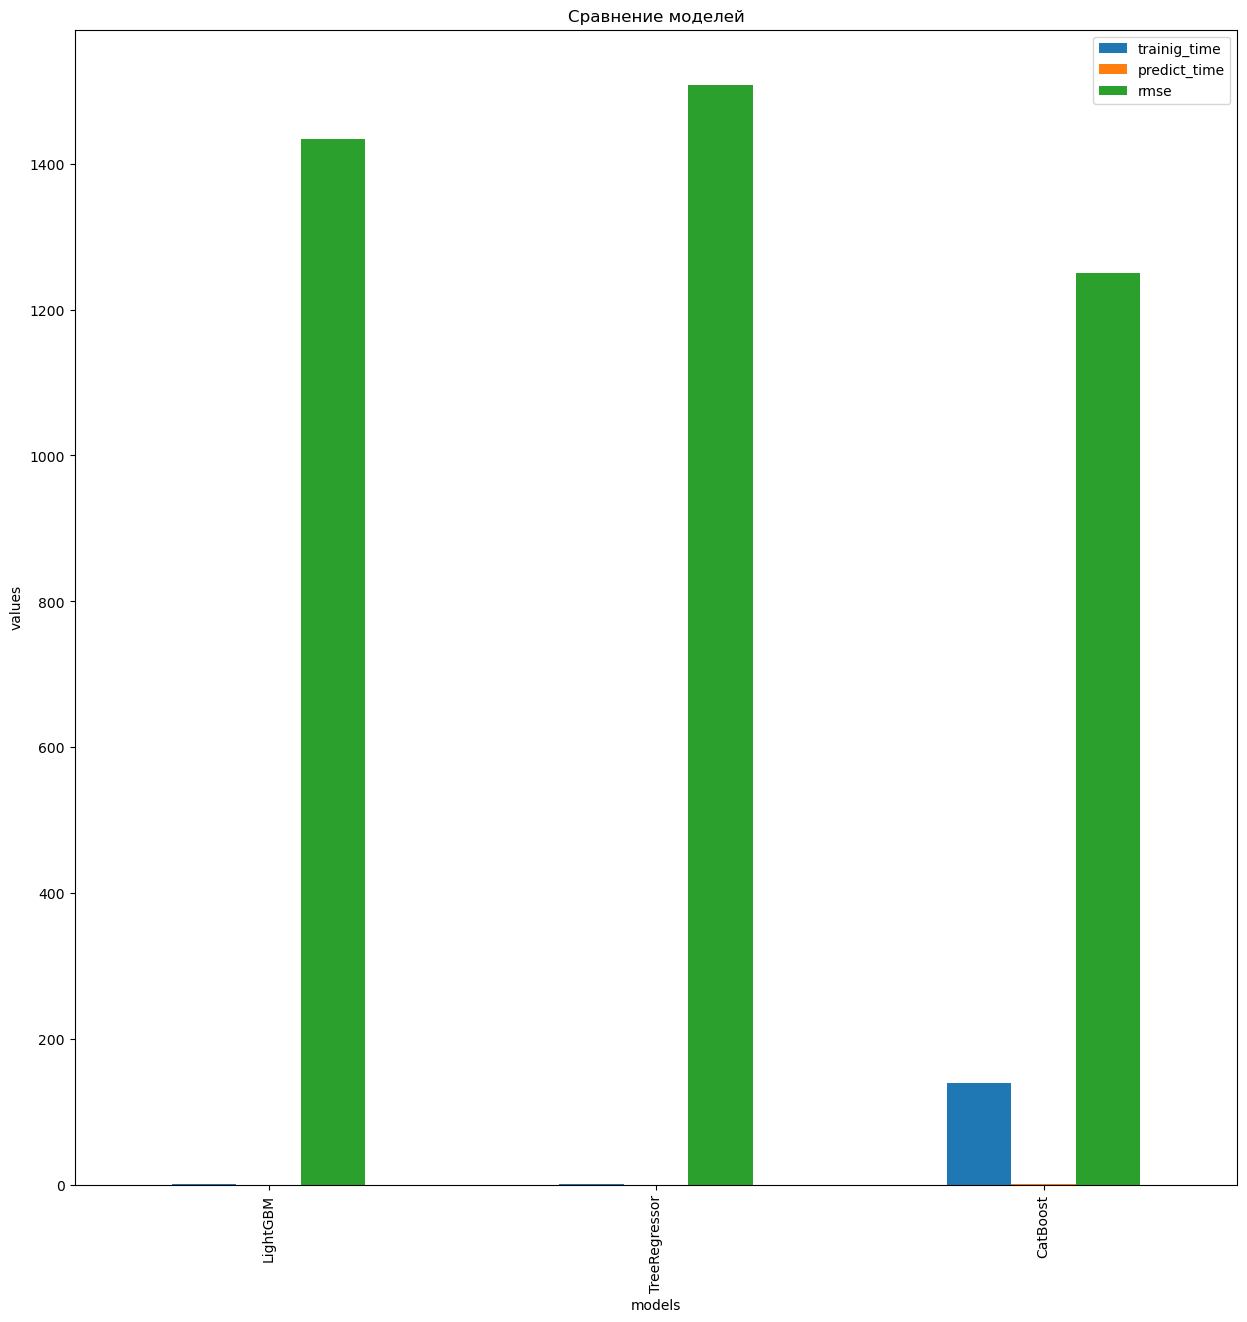

In [28]:

result_table.plot(kind='bar', legend=False, figsize=(15, 15))
plt.xlabel('models')
plt.ylabel('values')
plt.legend(list(result_table))
plt.title('Сравнение моделей')
plt.show()

In [29]:
start = time.time()
best_model = grid_lgbmr.best_estimator_
best_model.fit(features_train_enc, target_train)
end = time.time()
best_train_time = end-start

In [30]:
start = time.time()
predictions = best_model.predict(features_valid_enc)
end = time.time()

best_pred_time = end-start

In [31]:
best_rmse = (mse(predictions, target_valid)**0.5)

In [32]:
start = time.time()
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train_enc, target_train)
end = time.time()
dummy_train_time = end-start

In [33]:
start = time.time()
dummu_predict = dummy_regr.predict(features_valid_enc)
end = time.time()
dummy_predict_time = end-start

In [34]:
dummy_rmse = (mse(dummu_predict, target_valid)**0.5)

In [35]:
models_final = []
models_final.append([best_train_time , best_pred_time, best_rmse])
models_final.append([dummy_train_time , dummy_predict_time, dummy_rmse])

In [36]:
table_final = pd.DataFrame(data=models_final, 
                            index=['best_model','dummy_model'], 
                            columns=['trainig_time', 'predict_time', 'rmse']
                           )
table_final

trainig_time  predict_time         rmse
best_model       0.204978      0.021955  1411.586932
dummy_model      0.000000      0.002016  3450.560697

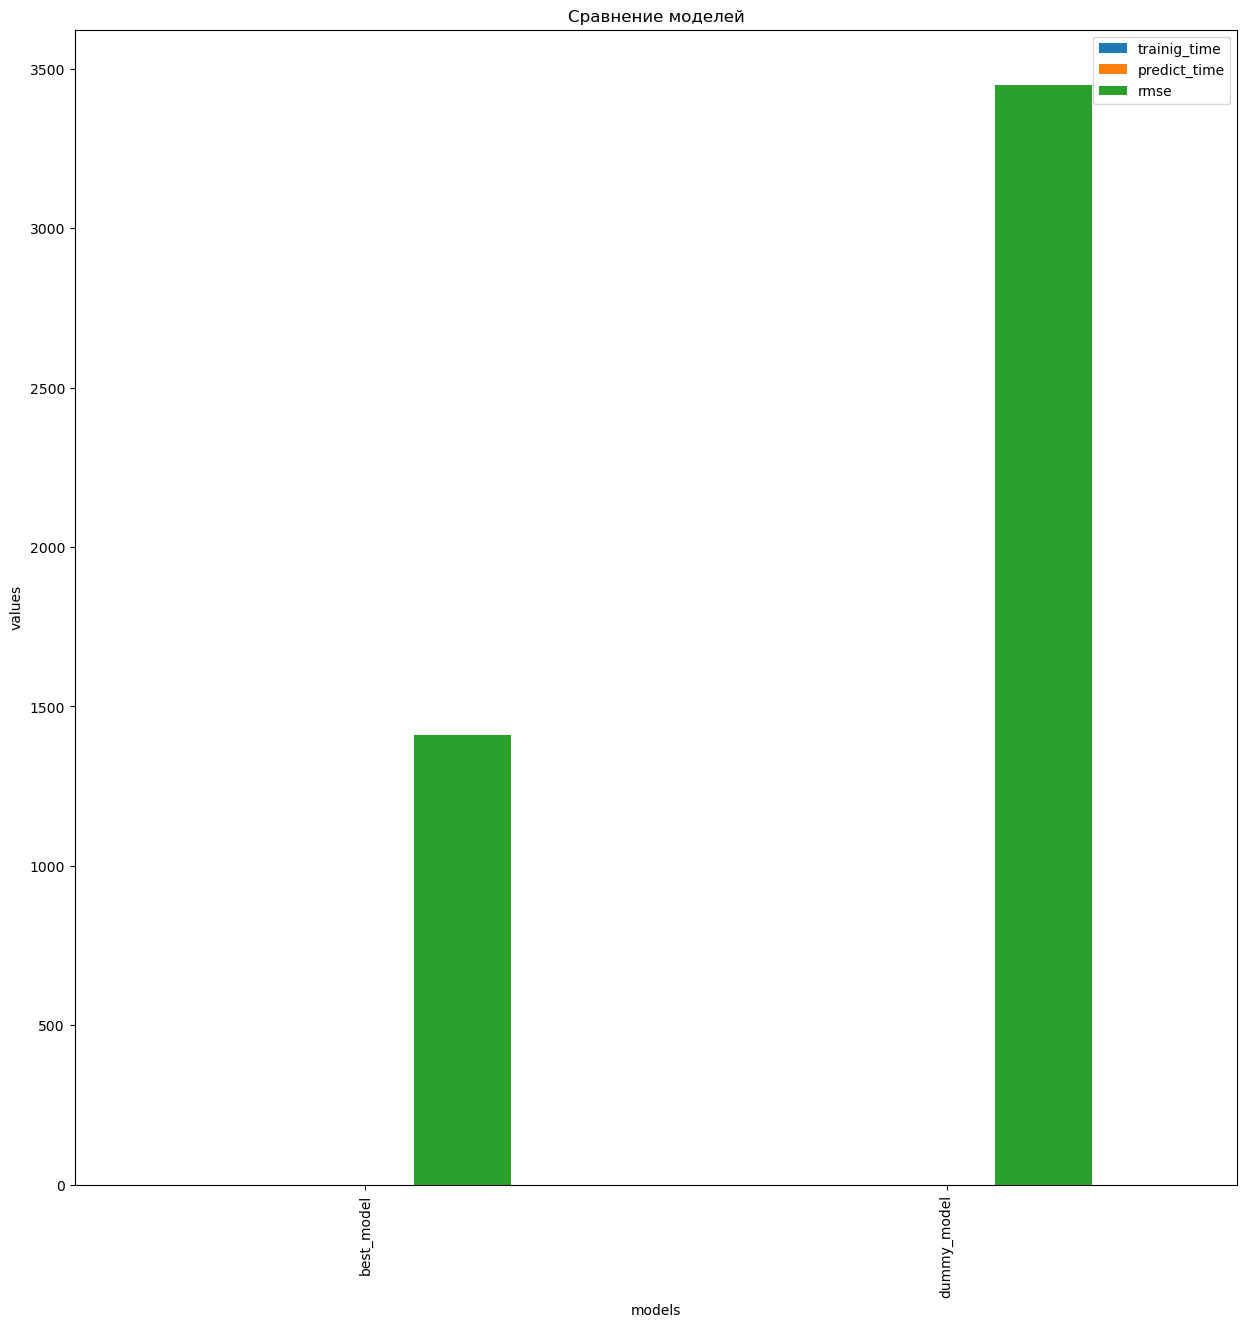

In [37]:
table_final.plot(kind='bar', legend=False, figsize=(15, 15))
plt.xlabel('models')
plt.ylabel('values')
plt.legend(list(table_final))
plt.title('Сравнение моделей')
plt.show()

- Лучшая модель по итогам исследования показывает значительно лучшие результаты , в сравнении с константой 

 - Модель TreeRegressor обучилась быстрее всех, но показала хучший результат
 - Модель CatBoostRegressor показала лучший результат, но очень долго обучалась
 - Модель LightGBM показала более оптимальный результат 

 # Вывод: 

- Загрузил данные
- Изучитил данные
- Подготовил выборки для обучения моделей.
- Обучил разные модели. Для каждой модели перебрал разные гиперпараметры.
- Проанализировал время обучения, время предсказания и качество моделей.
- Выберал лучшую модель, проверил её качество на тестовой выборке.
- Модель LightGBM показала более оптимальный результат 